## Minimal notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import requests

import seaborn as sns

from collections import Counter
import itertools

from matplotlib.colors import LogNorm, SymLogNorm, Normalize
from matplotlib.ticker import MaxNLocator, FormatStrFormatter

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import database

In [2]:
# always use False
LOCAL = False

if LOCAL:
    f = open('data/inspire_LA.json','r')
    df = json.load(f)
    f.close()
else:
    r = requests.get('https://github.com/restrepo/inspireauth/raw/main/data/inspire_LA.json')
    df = r.json()

db_master = pd.DataFrame(df)
db_master.head()

,author_id,country,email_addresses,full_name,ids,institution,institution_id,name,papers,positions,profile_id,advisors
0,H.Albrecht.1,Venezuela,"[{'value': 'hartwig.albrecht@desy.de', 'curren...","Albrecht, Hermann","[{'value': 'H.Albrecht.1', 'schema': 'INSPIRE ...","Unlisted, VE",912061,"{'value': 'Albrecht, Hartwig', 'preferred_name...","[{'recid': 2023395, 'year': '2021', 'citation_...",[{'record': {'$ref': 'https://inspirehep.net/a...,1018731,[]
1,D.M.B.R.1,Venezuela,None,"Bellorin, David","[{'value': 'D.M.B.R.1', 'schema': 'INSPIRE BAI'}]","Unlisted, VE",912061,"{'value': 'R., David M. Bellorin'}","[{'recid': 2023395, 'year': '2021', 'citation_...",None,2023397,[]
2,D.F.Mundarain.1,Chile,None,"Mundarain, Douglas F.","[{'value': 'D.F.Mundarain.1', 'schema': 'INSPI...",Catolica del Norte U.,908143,"{'value': 'Mundarain, Douglas F.'}","[{'recid': 2023395, 'year': '2021', 'citation_...",None,2023398,[]
3,R.Gaitan.2,Venezuela,"[{'value': 'rgaitan@uc.edu.ve', 'current': Fal...","Dominguez, Yessica","[{'value': 'R.Gaitan.2', 'schema': 'INSPIRE BA...","Unlisted, VE",912061,"{'value': 'Gaitan, Rolando', 'preferred_name':...","[{'recid': 1863076, 'year': '2021', 'citation_...","[{'rank': 'PHD', 'record': {'$ref': 'https://i...",1864347,[]
4,J.Ntahompagaze.1,Rwanda,None,"Ntahompagaze, Joseph","[{'value': 'J.Ntahompagaze.1', 'schema': 'INSP...","EAIFR, Kigali",1636656,"{'value': 'Ntahompagaze, Joseph'}","[{'recid': 2087212, 'year': '2022', 'citation_...",None,2087213,[]


# All countries in the database

In [3]:
# find all countries in json
all_countries = db_master['country'].unique()
# get rid of Nonetypes in the database
all_countries = [country for country in all_countries if country is not None]
# sort countries 
all_countries.sort()

print(len(all_countries))

for country in all_countries:
    print(country)
    
# format country 
def format_country(country):
    country = country.lower()
    ans = country.replace(" ", "_")
    return ans

115
Algeria
Argentina
Armenia
Australia
Austria
Azerbaijan
Bahamas
Bangladesh
Belarus
Belgium
Benin
Bhutan
Bolivia
Bosnia and Herzegovina
Brazil
Brunei Darussalam
Bulgaria
Canada
Chile
China
Colombia
Congo
Costa Rica
Croatia
Cuba
Cyprus
Czechia
Denmark
Dominican Republic
Ecuador
Egypt
El Salvador
Estonia
Ethiopia
Finland
France
Georgia
Germany
Ghana
Greece
Guatemala
Holy See (Vatican City State)
Honduras
Hungary
Iceland
India
Indonesia
Iran, Islamic Republic of
Iraq
Ireland
Israel
Italy
Jamaica
Japan
Jordan
Kazakhstan
Korea, Republic of
Kuwait
Kyrgyzstan
Latvia
Lebanon
Lithuania
Luxembourg
Madagascar
Malaysia
Malta
Mexico
Moldova
Mongolia
Montenegro
Morocco
Netherlands
New Zealand
Niger
Nigeria
North Macedonia
Norway
Oman
Pakistan
Palestine, State of
Panama
Paraguay
Peru
Philippines
Poland
Portugal
Puerto Rico
Qatar
Romania
Russian Federation
Rwanda
Saudi Arabia
Serbia and Montenegro
Singapore
Slovakia
Slovenia
South Africa
Spain
Sri Lanka
Sweden
Switzerland
Syrian Arab Republic
Taiwan

# Latin American countries 

In [4]:
# 19 Latin American countries indexed in the database
LA_countries = [
    'Argentina',
    'Bolivia',
    'Brazil',
    'Chile',
    'Colombia',
    'Costa Rica',
    'Cuba',
    'Dominican Republic', # new
    'Ecuador',
    'El Salvador', # new
    'Guatemala',
    'Honduras',
    'Mexico',
    'Panama', # new
    'Paraguay',
    'Peru',
    'Puerto Rico', # new
    'Uruguay',
    'Venezuela'
]

# Jamaica, Bahamas not included. 

LA_countries_format = [format_country(country) for country in LA_countries]

# Calculate h-index

In [5]:
# import default function

def hIndex(citations):
    """
    https://github.com/kamyu104/LeetCode/blob/master/Python/h-index.py
    :type citations: List[int]
    :rtype: int
    
    # Given an array of citations (each citation is a non-negative integer)
    # of a researcher, write a function to compute the researcher's h-index.
    #
    # According to the definition of h-index on Wikipedia: 
    # "A scientist has index h if h of his/her N papers have
    # at least h citations each, and the other N − h papers have
    # no more than h citations each."
    #
    # For example, given citations = [3, 0, 6, 1, 5], 
    # which means the researcher has 5 papers in total
    # and each of them had received 3, 0, 6, 1, 5 citations respectively. 
    # Since the researcher has 3 papers with at least 3 citations each and 
    # the remaining two with no more than 3 citations each, his h-index is 3.
    #
    # Note: If there are several possible values for h, the maximum one is taken as the h-index.
    """
    import builtins
    sum=builtins.sum
    return sum(x >= i + 1 for i, x in enumerate(sorted(  list(citations), reverse=True)))

In [6]:
# get h-index

def get_h_index(name_of_country):
    """
    This is a function. 
    """
    # select the country
    db=db_master[db_master['country']==name_of_country].reset_index(drop=True)
    
    # stack papers
    dp=pd.DataFrame(db.papers.apply(pd.Series).stack().to_list()).drop_duplicates(subset='recid').reset_index(drop=True)
    
    # calculate the h-index
    h_index = hIndex(dp.citation_count)
    print(f"{name_of_country} h-index = {h_index}")
    return h_index


In [7]:
def generate_hindex_all():
    ans = {}
    for country in LA_countries:
        ans[country] = get_h_index(country)
    return ans

h_index = generate_hindex_all();

Argentina h-index = 143
Bolivia h-index = 12
Brazil h-index = 191
Chile h-index = 167
Colombia h-index = 92
Costa Rica h-index = 51
Cuba h-index = 69
Dominican Republic h-index = 31
Ecuador h-index = 40
El Salvador h-index = 6
Guatemala h-index = 26
Honduras h-index = 4
Mexico h-index = 155
Panama h-index = 2
Paraguay h-index = 3
Peru h-index = 71
Puerto Rico h-index = 23
Uruguay h-index = 63
Venezuela h-index = 104


# Generate the histogram

In [8]:
# Population of each country

"""
Arrays account for 
- Argentina
- Bolivia
- Brazil
- Chile
- Colombia
- Costa Rica
- Cuba
- Dominican Republic
- Ecuador
- El Salvador
- Guatemala
- Honduras
- Mexico
- Panama
- Paraguay
- Peru
- Puerto Rico
- Uruguay
- Venezuela
"""

#populations = [45.606, 11.833, 213.993, 19.212, 51.266,
#               5.139, 11.318, 17.888, 18.250, 10.063,
#               130.262, 7.220, 33.359, 3.485, 28.705]

# population in millions of inhabitants
population = {element: None for element in LA_countries}

population['Argentina'] = 45.606
population['Bolivia'] = 11.833
population['Brazil'] = 213.993
population['Chile'] = 19.212
population['Colombia'] = 51.266
population['Costa Rica'] = 5.139
population['Cuba'] = 11.318
population['Dominican Republic'] = 10.954
population['Ecuador'] = 17.888
population['El Salvador'] = 6.158
population['Guatemala'] = 18.250
population['Honduras'] = 10.063
population['Mexico'] = 130.262
population['Panama'] = 4.382
population['Paraguay'] = 7.220
population['Peru'] = 33.359
population['Puerto Rico'] = 2.828
population['Uruguay'] = 3.485
population['Venezuela'] = 28.705

In [9]:
h_index_pc = {k: h_index[k] / population[k] for k in h_index}

In [10]:
h_index_pc

{'Argentina': 3.135552339604438,
 'Bolivia': 1.0141130736077073,
 'Brazil': 0.8925525601304716,
 'Chile': 8.692483864251509,
 'Colombia': 1.794561697811415,
 'Costa Rica': 9.9241097489784,
 'Cuba': 6.0964834776462276,
 'Dominican Republic': 2.830016432353478,
 'Ecuador': 2.2361359570661894,
 'El Salvador': 0.974342318934719,
 'Guatemala': 1.4246575342465753,
 'Honduras': 0.3974957766073735,
 'Mexico': 1.1899095668729176,
 'Panama': 0.4564125969876769,
 'Paraguay': 0.41551246537396125,
 'Peru': 2.1283611619053326,
 'Puerto Rico': 8.132956152758133,
 'Uruguay': 18.077474892395983,
 'Venezuela': 3.6230621842884516}

# Generate histogram

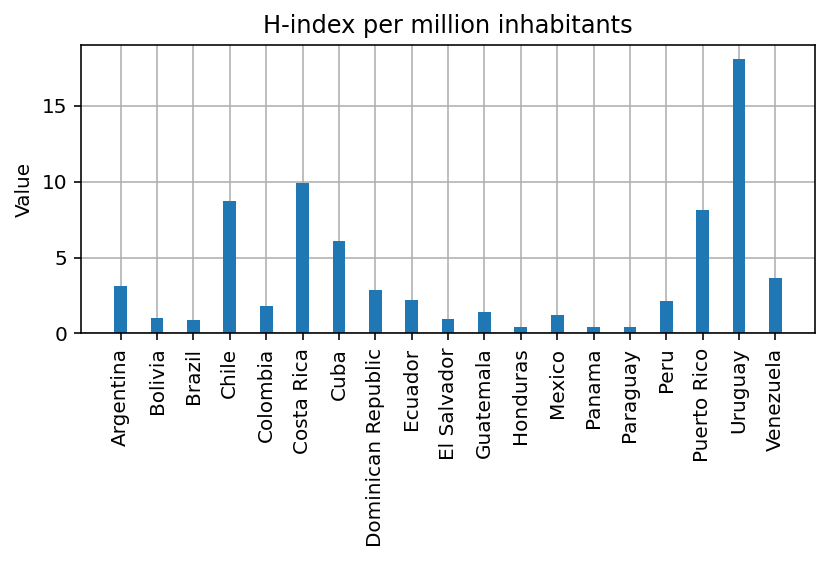

In [11]:
def gen_h_index_pc():

    labels = LA_countries
    data = h_index_pc.values()

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars
    fig, ax = plt.subplots()
    ax.bar(x, data, width)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.grid(True)
    ax.set_ylabel('Value')
    ax.set_title('H-index per million inhabitants')
    ax.tick_params(axis='x', rotation=90)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_axisbelow(True)

    fig.tight_layout()
    fig.savefig(f'../figures/h_index/all_h_index_pc.pdf', 
                dpi=150, bbox_inches = 'tight')

    plt.show()
    
gen_h_index_pc()

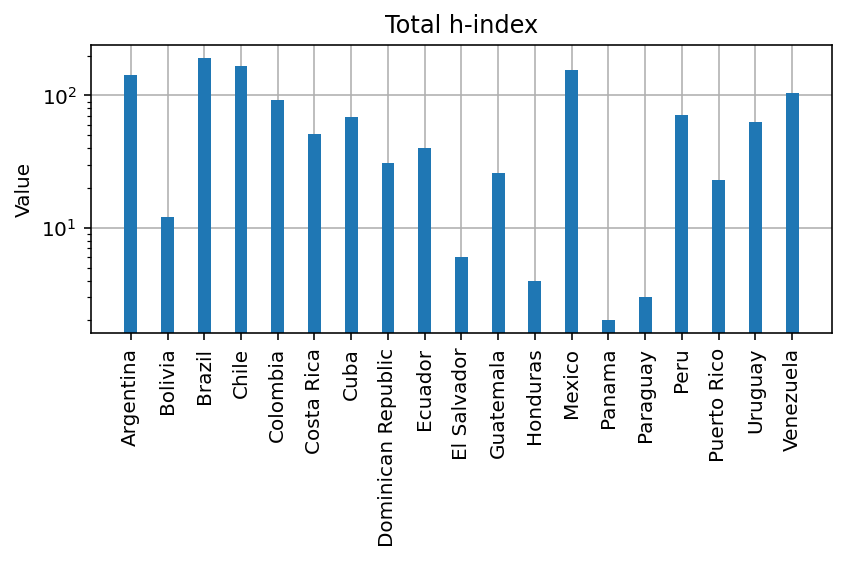

In [12]:
def gen_h_index_total():

    labels = LA_countries
    data = h_index.values()

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars
    fig, ax = plt.subplots()
    ax.bar(x, data, width)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.grid(True)
    ax.set_ylabel('Value')
    ax.set_title('Total h-index')
    ax.tick_params(axis='x', rotation=90)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_axisbelow(True)
    ax.set_yscale('log')

    fig.tight_layout()
    fig.savefig(f'../figures/h_index/all_h_index_total.pdf', 
                dpi=150, bbox_inches = 'tight')

    plt.show()
    
gen_h_index_total()

# Correlation with GDP

In [13]:
# GDP in R&D of each country

"""
Arrays account for 
- Argentina
- Bolivia
- Brazil
- Chile
- Colombia
- Costa Rica
- Cuba
- Dominican Republic
- Ecuador
- El Salvador
- Guatemala
- Honduras
- Mexico
- Panama
- Paraguay
- Peru
- Puerto Rico
- Uruguay
- Venezuela
"""

# GDPs taken from the World Bank
gdp = {element: None for element in LA_countries}

gdp['Argentina'] = 0.46
gdp['Bolivia'] = 0.16
gdp['Brazil'] = 1.21
gdp['Chile'] = 0.34
gdp['Colombia'] = 0.29
gdp['Costa Rica'] = 0.37
gdp['Cuba'] = 0.52
gdp['Dominican Republic'] = None # no info from the World Bank
gdp['Ecuador'] = 0.44
gdp['El Salvador'] = 0.17
gdp['Guatemala'] = 0.03
gdp['Honduras'] = 0.04
gdp['Mexico'] = 0.3
gdp['Panama'] = 0.15
gdp['Paraguay'] = 0.14
gdp['Peru'] = 0.17
gdp['Puerto Rico'] = 0.43
gdp['Uruguay'] = 0.48
gdp['Venezuela'] = 0.34

# Formatting parameters of the plot


In [14]:
colour_list = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
               '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
               '#008080', '#e6beff', '#9a6324', '#800000', 
               '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

# take care of the ValueErrors if no data is provided by the World Bank
def calculate_ratios(dict1, dict2):
    ratios = {}
    for key in dict1:
        if dict2[key] is not None:
            value1 = dict1[key]
            value2 = dict2[key]
            ratio = value1 / value2
            ratios[key] = ratio
    return ratios


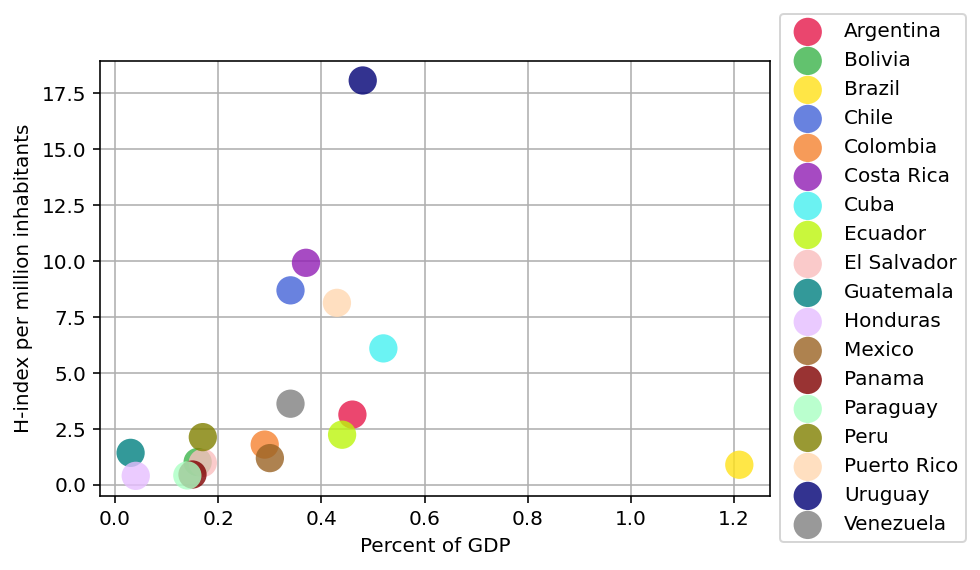

In [17]:
def gen_hindex_sp():
    
    fig, ax = plt.subplots()

    data = list(zip(LA_countries, 
                    gdp.values(), 
                    h_index_pc.values(), 
                    population.values()))
    
    for i in range(len(data)):
        # take care of the exceptions
        if data[i][1] is not None:
            x = data[i][1]
            y = data[i][2]
            r = data[i][3]  #radius
            #ax.scatter(x, y, label=data[i][0], s=10*r, alpha=0.8, c=colour_list[i], edgecolors='none')
            ax.scatter(x, y, label=data[i][0], s=200, alpha=0.8, c=colour_list[i], edgecolors='none')
    
    # format
    ax.set_xlabel('Percent of GDP')
    ax.set_ylabel('H-index per million inhabitants')

    ax.grid(True)
    ax.set_axisbelow(True)
    lgnd = ax.legend()
    handles = lgnd.legendHandles

    for handle in handles:
        handle._sizes = [50]

    # Specify the legend location outside the plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    fig.savefig(f'../figures/h_index/all_hindex_sp.pdf', 
                dpi=150, bbox_inches = 'tight')

    plt.show()
    
gen_hindex_sp()